# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)
*Дедлайн -- 31 декабря.*

*Хахулин Тарас (ФРТК МФТИ)*

Всем привет!
В этом домашнем задании вам предстоит применить знания современного фреймворка для работы с нейронными сетями Pytorch к задаче классфикации картинок.
Мы будем использоваться датасет Cifar10.

### Немного о разбалловке

Домашнее задание номер 7 состоит из двух частей - первая часть - это этот ноутбук, вторая часть - ноутбук по Transfer Learning, лежащий в этой же папке. Суммарно за оба ноутбука можно набрать 20 баллов. Точные критерии оценивания первой части задания установить сложно, поскольку она в большой степени творческая. Во втором задании указана разбалловка.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import os
import argparse

import matplotlib.pyplot as plt
import numpy as np

import math
from tqdm import tqdm_notebook, tqdm

## Данные:  cifar10

Для начала стоит разобраться, что у нас за датасет

[cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) состоит из 10 классов картинок: самолет, автомобиль, птица, кошка, олень, собака, лягушка, лошадь, корабль, грузовик.

Изображения в CIFAR-10 имеют размер 3x32x32, т.e. nтрехканальные цветные изображения размером 32x32 пикселя.

In [ ]:
print('Preparing data.')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Сейчас мы скачаем необходимый датасет в папку data. Для этих целей в torchvision есть удобный функционал.

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=4)

Посмотрим что же мы скачали

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
%matplotlib inline
def imshow(img):
    """Show img"""
    img = img/2
    npimg = img.numpy()/2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = dataiter.next() 
# show images and labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%8s' % classes[labels[j]] for j in range(4)))

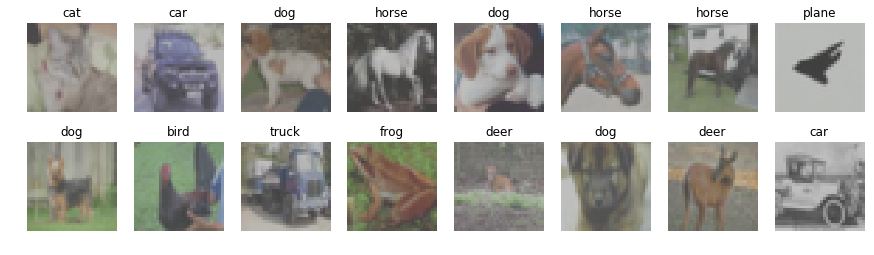

In [6]:
# more images
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

dataiter = iter(testloader)
images, labels = dataiter.next() 
images2, labels2 = dataiter.next()
labels = torch.cat((labels, labels2))
images = torch.cat((images, images2))
for i in range(cols):
    images, labels = dataiter.next()
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        imshow(images[j])
        ax.set_title(i)
        ax.set_title(classes[labels[j]])
plt.show()

###  Решение задачи классификаиции сверточными сетями

Основная задача построить классификатор, который будет понимать что изображено на картинке.

In [ ]:
def accuracy(out, labels):
    _, pred= torch.max(out.data, 1)
    return (pred == labels).sum() / labels.size(0)


Ниже предлагается реализовать простейшую сверточную сеть. Пример архитектуры с парамнтрами представлен ниже.

In [ ]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            <conv2d (5, pad 1, stride 2) out=64>
            <batch norm>
            <relu>
            <maxpool>
            add analogical layer
            <conv2d (5, pad 1, stride 2) out=127>
            <batch norm>
            <relu>
            <maxpool>
        )
        self.classifier = nn.Sequential(
            <linear layer:shape in view>
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128*8*8)
        x = self.classifier(x)
        return x

Теперь будем тренировать нашу сеть. Количество эпох необходимое для обучения( не забывайте про overfit) требуется подобрать самому, как и learning rate. Также рекомендуется рисовать кривые обучения с помощью сохраняемых данных.

In [ ]:
def train(trainloader, testloader, reuse=False):
    N = len(trainloader)
    print('Length {} of trainset: '.format(N))
    print('Length {} of testset: '.format(len(testloader)))

    # create model
    cnn = CNN()
    if reuse:
        cnn.load_state_dict(torch.load('save/simple_cnn.pth'))
    <loss : cross entropy>
    <adam optimizer>

    # train
    loss_history = []
    time_history = []
    epochs = 1
    for epoch in range(epochs):
        loss_cum = 0.0
        acc_cum = 0.0
        time_cum = 0.0
        for i, (imgs, labels) in enumerate(tqdm(trainloader)):
            imgs, labels = <imgs for torch>, <labels for torch>
            cnn.zero_grad()

            outputs = # out of your network
            loss = criterion(outputs, labels)
            #<backward>
            #<optimizer_step>
            loss.backward()
            optimizer.step()

            loss_cum += loss.data[0]
            if i%1000 == 0:
                # <add validation if you want>
                loss_history.append(loss_cum/N)
                time_history.append(time_cum)
                torch.save(cnn.state_dict(), 'save/simple_cnn.pth')
    # test accuracy
    cnn.eval()
    correct, total = 0, 0
    for imgs, labels in testloader:
        imgs, labels = Variable(imgs), labels
        outputs = cnn(imgs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum()

    print('mean accuracy on %d test images: %f' % (total, correct/total))

    # save histories
    anp.savetxt('loss_history.csv', loss_history)
    np.savetxt('time_history.csv', time_history)
    # save models
    torch.save(cnn.state_dict(), 'save/simple_cnn.pth')
    return cnn # remove if you save model correctly

In [ ]:
simple_cnn = train()

In [ ]:
model = CNN()
model.load_state_dict(torch.load('save/simple_cnn.pth'))

In [ ]:
dataiter = iter(testloader)
dataiter.next()
images, labels = dataiter.next()

outputs = model(Variable(images))
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
cnn = train(reuse=True)

Какой максимальный результат был получен при такой архитектуре?

Как бы вы улучшили данную сеть? По итогам последней лекции 

На этом задание не заканчивается, как вы видите такая комбинациия двух сверточных слоев не дает достаточного результата. Далее задача становится творческой. Вам предлагается улучшить архитектуру, чтобы увеличить скор (он скорее всего сильно вырастет). 
Используйте инициализацию весов о которой вам рассказывали. 

Инициализировать веса в pytorche можно таким образом(рекомендуется попробовать различные варианты инициализации):

In [ ]:
class Simple_CNN_with_weights_initializer(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(

        )
        self.classifier = nn.Sequential(
        )
        self._initialize_weights()

    def forward(self, x):
        pass
    
    def _initialize_weights(self):
    """ Init weight parameters """
        pass

Если хочется еще улучшить качество модели, то можно попробовать реализовать дополнительные архитектуры.

Предлагаемые архитектуры для реализации: vgg11, alexnet, resnet